# Assignment #5


Deep Learning / Spring 1398, Iran University of Science and Technology



---



**Please pay attention to these notes:**

<br/>

- **Assignment Due:**  1398/04/19 23:59
- If you need any additional information, please review the assignment page on the course website.
- The items you need to answer are highlighted in red and the coding parts you need to implement are denoted by:
```
########################################
#     Put your implementation here     #
########################################
```
- We always recommend co-operation and discussion in groups for assignments. However, each student has to finish all the questions by him/herself. If our matching system identifies any sort of copying, you'll be responsible for consequences. So, please mention his/her name if you have a team-mate.
- Students who audit this course should submit their assignments like other students to be qualified for attending the rest of the sessions.
- Finding any sort of copying will zero down that assignment grade and also will be counted as two negative assignment for your final score.
- When you are ready to submit, please follow the instructions at the end of this notebook.
- If you have any questions about this assignment, feel free to drop us a line. You may also post your questions on the course's forum page.
- You must run this notebook on Google Colab platform; there are some dependencies to Google Colab VM for some of the libraries.
- **Before starting to work on the assignment please fill your name in the next section AND Remember to RUN the cell.**

<br/>


Assignment Page: https://iust-deep-learning.github.io/972/assignments/05_rnn_in_depth

Course Forum: [https://groups.google.com/forum/#!forum/dl972/](https://groups.google.com/forum/#!forum/dl972/)



---



Fill your information here & run the cell

In [0]:
#@title Enter your information & "RUN the cell!!"
student_id = 0 #@param {type:"integer"}
student_name = "" #@param {type:"string"}
Your_Github_account_Email = "" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


from pathlib import Path

ASSIGNMENT_PATH = Path('asg05')
ASSIGNMENT_PATH.mkdir(parents=True, exist_ok=True)

# 1. RNN in depth

We have investigated some text-based neural network in the previous assignment. Now we want actually to implement an advanced, research-ready LSTM network. We will train it in a memory-friendly setup, and bring *residual connection* and *pooling layer* from Computer vision to improve its performance.

## 1.1 RNN input

In this section, we will go through all the details until we reach at a complete RNN pipeline implementation. Three conditions need to be taken into consideration when we're thinking about the RNN input. 
1. Formally, neural networks have inputs which are fixed in both size and shape, e.g., a 32x32 image, but in contrast inputs to an RNN network are variable-length sequences. 
2. Size and shape of any tensor in our neural network should be precisely defined at run time. 

So far, so good. We can feed one sample at a time to pass those conditions. But this is when the third condition appears.
3. Generally, Stochastic Gradient Descent is referred to as a practical solution in the machine learning vocabulary, but actually, it is a theoretical approach which was first introduced in 1951 [1] as a stochastic gradient approximation technique, In other words, we cannot train a neural network with batch size = 1, we need more samples in each traning step to have a reasonable gradient approximation. So feeding one variable length input at a time will not work.

As you may know, one possible solution is to pad the inputs to have the same lengths. First, we find the maximum possible length by looking at our dataset; then we pad any other samples with zeros to have the same length as the sample with maximum length. Here is an example from our codes in the class:


In [0]:
import random
import numpy as np
from pprint import pprint
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 12
MIN_LEN = 1

# Create variable length sequence dataset
seq_list = [[random.randint(0, 100) for _ in range(random.randint(MIN_LEN, MAX_LEN))] for _ in range(15)]
print("# Un-padded dataset")
pprint(seq_list)

# Create a padded version
print("\n # Padded version")
padded_seq_list = pad_sequences(seq_list, padding='post')
padded_seq_list

Batching is also easy. We can directly create the chunks from `padded_seq_list`. All of them have a fixed `[batch_size, MAX_LEN]` shape.

In [0]:
BATCH_SIZE = 5

for i in range(0, len(padded_seq_list), BATCH_SIZE):
  batch = padded_seq_list[i:i+BATCH_SIZE]
  print("# Batch #%s, shape = %s"%(i//BATCH_SIZE, batch.shape))
  pprint(padded_seq_list[i:i+BATCH_SIZE])

It seems everything is alright, and we can jump straight into the implementation. But can you spot the huge waste of space? Do all of the batches have some sequence with the maximum length? Of course not! Let's imagine a real-world example; Generally, a text classification corpus has a large number of sentences. However, their length roughly follows the normal distribution (say $\mu = 40$). That is, most of our sentences are within the distribution mean range. But always we have long sentences with a length even bigger than 100. Now you can guess how much space we would have lost if we had set the `MAX_LEN = 100`.

## 1.2 Solution: Batching with variable `MAX_LEN`

So instead of setting max_len to the dataset's maximum, we can set it for each individual batch. In other words, we will have different max_len across our batches. In this case, we not only pass the 3-fold conditions, but also are much more memory efficient. Let's rewrite the above example to illustrate this idea.

In [0]:
BATCH_SIZE = 5

for i in range(0, len(padded_seq_list), BATCH_SIZE):
  batch = seq_list[i:i + BATCH_SIZE]
  padded_batch = pad_sequences(batch, padding='post')

  print("# Batch #%s, shape = %s"%(i//BATCH_SIZE, padded_batch.shape))
  pprint(padded_batch)

As you can see, we've saved some memory in our artificial example. Let's jump back to our case when the sequences are real sentences. What does this input tensor really mean? Recall that the RNN input is a 3d tensor, but here we have 2d arrays. Actually, this 2d array is simply small number of sentences gathered together to construct one batch, and each word is replaced with its ID from the vocabulary 

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg05_assets/01_lstm_input_2d.png" width="850"/>   
</p>
<p align="center">Figure 1. Batch size = 3, and W<sub>i</sub> = Word ID assigned by the vocabulary, and 0 is reserved for padding; Here max_len = 6, and sentence 1 and 3 are padded to match up with the longest sentence</p>

This 2d array is the actual input that we feed into our network. However, there is one more step. As mentioned earlier, an RNN input must be a 3d tensor. A typical input shape for an RNN is something like `[batch, max_len, features]`. Up to this point, we have `[batch, max_len]` with another dimension left. In NLP, features are simply the word embeddings. So let's bring our embedding layer to create the final tensor:

</br>
<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg05_assets/02_lstm_input_3d.png" />   
</p>
</br>
<p align="center">Figure 2. E<SUB>i</SUB> is the embedding vector for word W<sub>i</sub>. This tensor has [batch = 3, max_len = 6, features = 300 ] shape, and is ready to be fed into an RNN network directly.  </p>

Some time steps are grayed out by the masking layer. It simply hides these steps from the upcoming layers (here the upcoming layer is the RNN network). By masking these inputs we tell the RNN network to skip the grayed out inputs and continue the computation on the remaining sequences.

As the figure denotes it, this 3D tensor is then split into its time steps so that each RNN step will receive a vertical 2d slice. With that said, the shape of an RNN cell input is `[batch, word_dim]` as well as its previous hidden state which has `[batch, hidden_dim] ` shape.

 ## 1.3 Batches with variable MAX_LEN Implementation

To implement the batching system with variable time-steps, we need to use handy tools that come with the Keras framework. As you might remember, the whole dataset has to be passed to `model.fit(...)` when we want to train the model. However, Keras provides another way to train our model. Indeed, `model.fit_generator(generator, ...)` is useful when we want to feed the data batches manually and one-by-one. 

As explained by [Keras documentations](https://keras.io/models/model/), the generator parameter must output a tuple `(inputs, targets)` where `inputs` are model's inputs, and `targets` are the labels corresponding to the inputs. This tuple forms a single batch. Naturally, the length for the input and output array should be similar for every batch but can have completely different sizes and shapes across all batches. Implement described batching system in the following class:

In [0]:
import numpy as np
from keras.utils import Sequence


class VariableLengthGenerator(Sequence):
  """Implements an efficient variable-length batch generator.
    The value of Time step dimension is calculated accroding to the longest sequence 
    in each batch.
  """
  def __init__(self, X, Y, batch_size, num_classes, shuffle=False):
    """
    the class instructor.
    Args:
      X (list[list[int/float]]): A sequence input data
      Y (list[int]): Target labels coresponding to ith element
      batch_size (int): Pre-defined batch size
      num_classes (int): Number of target classes. 
         To use with keras.utils.to_categorical
      shuffle (boolean): Enable dataset shuffling after each epoch
    """
    ########################################
    #     Put your implementation here     #
    ########################################
    
  
  def __len__(self):
    """
    Denotes the number of batches per epoch
    Returns:
      len (int): number of batches per epoch
    """
    ########################################
    #     Put your implementation here     #
    ########################################
    
    return 0
  
  def __getitem__(self, idx):
    """
    Generate idx-th batch of dataset.
    
    Args:
      idx (int): the batch index
      
    Returns:
      A tuple: (
        input batch (numpy.array(shape=[batch_size, batch_max_len])),
        target batch (numpu.array(shape=[batch_size, num_classes], dtype=np.int))
      )
      
    Hint: First find the sentence with the maximum length within the batch (batch_max_len). 
      then pad any other sentence with zero to match up with the batch_max_len
    """
    
    x = None
    y = None
    
    ########################################
    #     Put your implementation here     #
    ########################################
    
    return (x, y)
  
  def on_epoch_end(self):
    """
    This method is called after each epoch,
      you can use it to shuffle dataset on every epoch.
    """
    ########################################
    #     Put your implementation here     #
    ########################################

In [0]:
# Test your implementation
fake_input = [[1,3,4,3,4,5,2,3], [34,38,3], [93,499,5,95,3],[93,4,2,3], [4,3,94,4,5]]
fake_target = [0,2,2,1,3]
fake_gen = VariableLengthGenerator(fake_input, fake_target, 2, 5)

batch_1_inputs, batch_1_targets = fake_gen[0]

assert len(fake_gen) == 3
assert batch_1_inputs.shape == (2, 8)
assert batch_1_targets.shape == (2, 5)

ref_batch_1_inp = np.array(
    [[1,3,4,3,4,5,2,3],
     [34,38,3,0,0,0,0,0]], dtype=np.int32)

are_equal = ref_batch_1_inp == batch_1_inputs
assert np.all(are_equal)

ref_batch_1_tgts = np.array(
    [[1,0,0,0,0],
     [0,0,1,0,0]], dtype=np.int32)

are_equal = ref_batch_1_tgts == batch_1_targets
assert np.all(are_equal)
print('Passed!')

## 1.4 Residual LSTM cell

In neural networks, we believe that every new additional layer is adding more representation power to the model. More layers mean more abstractions and hopefully, better performance. But can we go deep and deeper as we want?
Unfortunately the answer to this question is "no"; In practice, It is proven that naively making our model deep will always result in worse performance. The problem here is rooted in the training algorithm, i.e., Backpropagation. Having more layers result in more dimmed, vanished error signals. Therefore, early layers will have no idea about what they are doing wrong since the received error signal is quite faded.

One of the simple but smart ideas to address this problem is Residual connections. It directly connects every single layer to the final output, which is considered as the primary source of the error signal. In other words, it makes the error signal propagation more efficient. In other words, it creates some kind of *highway* for neural network blocks to put their input on and receive high-quality error signal in the backward pass. In residual connections, ther input is added to the output along with neural network block result. i. e.  $y = F(x) + x$ where $F(x)$ is some neural network building block. 

</br>
<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg05_assets/03_residual_connection.png" width="400" />   
</p>

<p align="center">Figure 3. A residual connection with two neural network blocks.  </p>

Residual connections were originally introduced in 2015 \[2], primarily for image recognition networks. However, recurrent neural networks are no different from deep networks in terms of their deepness. In fact, RNNs unfold themselves to match their input sequence, which consequently creates a deep network. So, why not try residual connections on RNNs?


<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg05_assets/04_residual_lstm.png" width="400" />   
</p>

<p align="center">Figure 4. Residual recuarrent neural network with multi layer LSTM cells.  </p>

In an LSTM network, we can add residual connections between distinct layers to make dataflow simpler. Note that this connection is restricted to a single feedforward step of RNN. That is, LSTM cells cannot be connected across steps. It is intresting to know that Google has trained a huge deep neural machine translation system with 8 LSTM layers by incorporating this architecture for Google Translate. 

There are no residual connections in the first layer. Why? How can you fix this?


$\color{red}{\text{Write your answer here}}$


### Implementation

In this section, our goal is to implement a Residual LSTM cell to be used with `keras.layer.RNN` class. `RNN` class is a handy tool from Keras library; it simply unfolds the network with the given **cell**. This **cell** parameter could be anything such as LSTM, GRU, or even SimpleRNN cell. We will leverage this functionality to create a residual wrapper around the LSTM cell. The idea for the wrapper is to first run the LSTM cell with the provided input and then create its output by summing over the input and the LSTM output.

To make things easier, we skip the wrapper function and directly inherit our cell from `LSTMCell`. By using this approach, we'll lose some flexibility in exchange for convenience. Please remember the context for `call(..)` method is a single running RNN step, and its input is consequently a 2d slice of the whole RNN input which makes its shape in the form of  `[batch, features]`

In [0]:
from keras.layers import LSTMCell

class ResidualLSTMCell(LSTMCell):
  """LSTM extension to with residual connection"""
  
  def __init__(self,units, **kwargs):
      super(ResidualLSTMCell, self).__init__(units, **kwargs)
      
  def call(self, inputs, states, training=None):
    """Run single step of RNN.
    
    Args:
      inputs (Tensor): input for this step x_t. Shape: [batch, features]
      states: An lstm internal state data structure
    
    Returns:
      (outputs, states): A tuple representing cell output, and the modified state
       
    Hints: call the parent class method, and then 
      create the final output from the original input and
      actual lstm cell output. Do not touch the states parameter.
    """
    
    output = None
    new_states = None
    
    ########################################
    #     Put your implementation here     #
    ########################################
    
    return output, new_states

Test your implementation

In [0]:
import numpy as np
from keras import backend as K

lcell = LSTMCell(3, activation=None, recurrent_activation=None, use_bias=True,
                kernel_initializer='ones', recurrent_initializer='ones',
                bias_initializer='zeros')

rcell = ResidualLSTMCell(3, activation=None, recurrent_activation=None, use_bias=True,
                kernel_initializer='ones', recurrent_initializer='ones',
                bias_initializer='zeros')

states = (K.constant(np.zeros([1,3])),K.constant(np.zeros([1,3])))
inputs = K.constant(np.ones([1,3]))

lcell.build(input_shape=(1, 3))
rcell.build(input_shape=(1, 3))

loutput, _ = lcell.call(inputs, states)
routput, _ = rcell.call(inputs, states)

assert K.eval(K.all(K.equal(routput-loutput,inputs)))
print("Passed")

## 1.5 Max-pooling through time

Another technique that originates from Computer Vision is called Max pooling. As you might remember, this technique reduces the impact of spatial information in the image. For example, If your CNN says, "Yay! I found a wheel at the position (x,y).", your Max-pooling will convert this sentence to "Yay! I found a wheel in this image."  Intuitively We can use the max-pooling procedure in any configuration beside an image. Here is an example of Max-pooling application in recurrent networks:

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg05_assets/05_rnn_max_pooling.png" width="450" />   
</p>
<p align="center">Figure 5. Max-pooling through an RNN's hidden states.  </p>

In this setup, we'd like to perform max-pooling over the hidden states $\hat{h} = MaxPool([h^{(1)}, ..., h^{(n)}])$ where $\hat{h}$ is the max-pooled version. Every dim of $\hat{h}$ is the maximum of that particular dim across all of the hidden states.

$$
\hat{h}_i =\max_{1\le k \le n} h^{(k)}_i
$$

Explain why do you think max-pooling through time will help model's performance?

$\color{red}{\text{Write you answer here}}$

### Implementation

The default Keras framework provides the implementation but unfortunately it doesn't support masking. We need to max pool only over valid time steps. Implement this mechanism as a Keras layer.

In [0]:
from keras.layers import Layer

class MaskedGlobalMaxPooling1D(Layer):
  """
  Max pooling over time steps
  """
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.supports_masking = True
  
  def compute_output_shape(self, input_shape):
    return (input_shape[0], input_shape[-1])

  def compute_mask(self, input, input_mask=None):
    return None
  
  def call(self, inputs, mask=None):
    """
    Args:
      inputs (Tensor(dtype=float32)): shape = [batch, timesteps, featurs]
      mask (Tensor(dtype=bool)): shape = [batch, timesteps]
      
    Returns
      output (Tensor(dtype=float32)): shape = [batch, features]
      
    Hint: K.tf.where, K.tile, K.max could be helpful.
    """
    
    output = None
    
    ########################################
    #     Put your implementation here     #
    ########################################
    
    return output

Test your implementation

In [0]:
import numpy as np
from keras import backend as K

seq = K.constant( [ 
    [[1, 3],
     [4, -2],
     [0, 11]],
    
    [[9, -3],
     [8, -2],
     [100, -5]]
])
mask = K.constant([
    [True, True, True],
    [True, True, False]
], dtype='bool')

max_pooled = MaskedGlobalMaxPooling1D()(seq, mask=mask)
max_pooled = K.eval(max_pooled)

print(max_pooled)
assert np.all(max_pooled == np.array([[ 4., 11.],
       [ 9., -2.]]))
print("Passed!")

## 1.6 Trainable initial state

RNNs are stateful neural networks. They use this state to represent and store context information. They can add, delete, and modify their states in each step; yet, the initial value for this state vector is kind of unknown. A common approach is to start it with all-zero tensor. However, it is proved that this approach has some drawbacks. Another method is to consider the initial state as a trainable parameter, which means that the initial state can likely reach an optimal value to start the RNN.

Fortunately You can specify the initial state in keras `RNN` class.

In [0]:
from keras import backend as K
from keras.layers import Input, RNN, LSTMCell, Lambda, concatenate

word_dim = 300
hidden_dim = 200

inp = Input((None, word_dim))

# Fake identity layer to use its add_weights(...) method
# We need to create this layer because of Keras limitations
iden = Lambda(lambda x: x)
x = iden(inp)
batch_size = K.shape(x)[0]

def create_trainable_initial_state(name_prefix):
  h = iden.add_weight('%s_h' % name_prefix, shape=(1, hidden_dim), initializer='zeros')
  c = iden.add_weight('%s_c' % name_prefix, shape=(1, hidden_dim), initializer='zeros')

  # Make sure they match with shape [batch_size, hidden_dim]
  h = K.tile(h, [batch_size, 1])
  c = K.tile(c, [batch_size, 1])

  return h, c

# Create trainable variables for initial states
# Forward
fw_h, fw_c = create_trainable_initial_state('fw')
# Backward
bw_h, bw_c = create_trainable_initial_state('bw')

# Create simple single layer RNN
fw_rnn = RNN(LSTMCell(hidden_dim), return_sequences=True)
bw_rnn = RNN(LSTMCell(hidden_dim), return_sequences=True, go_backwards=True)
y_fw = fw_rnn(x, initial_state=[fw_h, fw_c])
y_bw = bw_rnn(x, initial_state=[bw_h, bw_h])
y = concatenate([y_fw, y_bw], axis=-1)
y

## 1.7 Train

### Putting it all together 

Having all parts ready, we can now build our advanced deep memory efficient RNN classifier. You should first implement a multi-layer LSTM bidirectional recurrent neural network with residual connections. Set its initial states to a trainable parameter. Then put Max-pooling layer on top of that in order to reduce all hidden states in a single vector, and finally Feed the computed vector into a multi-layer dense network to get the final predicted label. Here is a complete figure for our advanced model:

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg05_assets/06_final_network.png" width="800" /> </p>


Hints:
1. Create an Embedding layer to convert word ids to thier corresponding embeddings. Use `layers.Embedding` class and remember to pass `mask_zero=True` in its paramters.
2. Create the RNN part:
 1. Unfortunately Keras `Bidirectional` layer is corrupted. You need to create two separate RNNs, one for forward (`fw_rnn = RNN(..., goes_backwards=False)`) and one for the backward direction (`bw_rnn = RNN(..., goes_backwards=True)`).
 2. Make sure that you've created two sets of Residual LSTM cells (`fw_cells, bw_cells`) and two sets of initial states (`fw_initial_states, bw_initial_states`).
 3. Then concatenate both hidden states to create the final output of a bidirectional multi-layer residual LSTM network (you may find `keras.layers.concatenate([...], axis=-1) useful`.
3. Reduce hidden states to the max pooled version via our `MaskedGlobalMaxPooling1D` layer.
4. Create a dense multilayer network to predict the output label from the max-pooled hidden state.

Hyperpramaneters definition

In [0]:
HIDDEN_NUM = 128
NUM_RNN_LAYERS = 3
EMBEDDING_DIM = 300
DENSE_HIDDEN_LAYERS = [64, 32]
DROPOUT_RATE = 0.4
VOCAB_SIZE = 10*1000
BATCH_SIZE = 128
NUM_CLASSES = 4

In [0]:
from keras.models import Model
from keras.layers import Input, Lambda

def create_advanced_rnn(embedding_matrix, num_classes):
  """Create an advanced LSTM text classifier
  
  Args:
    embedding_matrix (np.array(shape=(vocab, EMBEDDING_DIM))): word embedding matrix
    num_classes (int): num of tar classes
    
  Returns:
    model (keras.Model)
  """
  # Input specs
  x = Input((None,))
  
  # Fake layer to add any additional weights
  iden = Lambda(lambda x:x)
  
  # The real input, shape: [batch_size, time_steps]
  word_ids = iden(x)
  
  ########################################
  #     Put your implementation here     #
  ########################################
  
  y = None
  model = Model(inputs=x, outputs=y)  
  
  return model

Check your implementation

In [0]:
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

m = create_advanced_rnn(np.zeros((10, EMBEDDING_DIM)), 5)
m.summary()

SVG(model_to_dot(m).create(prog='dot', format='svg'))

### Data Preparation 

Similarly to the previous assignment, we will use AG News dataset to train our model. Here a description from assignment 04:

`The task is text classification on the AG News corpus, which consists of news articles from more than 2000 news sources. Our split has 110K samples for the training and 10k for the validation set. Dataset examples are classified into 4 major topics: {World, Sports, Business, Sci/Tech}`

</br>

Let's download the dataset

In [0]:
! wget -q https://iust-deep-learning.github.io/972/static_files/assignments/asg04_assets/data.tar.gz
! tar xvfz data.tar.gz > /dev/null

from ag_news_util import read_ag_news, AG_NEWS_LBLS

! pip install -q tqdm flair
from tqdm import tqdm
from flair.data import Sentence

In contrast to assignment 04, the processing step is minimal here; we just need to tokenize sentences and convert words to their lower case version.

In [0]:
def tokenize(sent):
  sent = Sentence(sent, use_tokenizer=True)
  str_tokens = [t.text.lower() for t in sent.tokens]
  return str_tokens

(train_sents, train_lbls), (valid_sents, valid_lbls) = read_ag_news()

train_tok_sents = list(map(tokenize, train_sents))
valid_tok_sents = list(map(tokenize, valid_sents))

Download glove pre-trained word embedddings:

In [0]:
! wget "http://nlp.stanford.edu/data/glove.6B.zip" -O glove.6B.zip && unzip glove.6B.zip

word2vec = {}
with open('glove.6B.300d.txt') as f:
  for line in tqdm(f, total=400000):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word2vec[word] = coefs

print('Found %s word vectors.' % len(word2vec))

Replace tokens with their ids:

In [0]:
from collections import Counter

PAD_TOK = '<pad>'
UNK_TOK = '<unk>'
special_toks = [PAD_TOK,UNK_TOK]

def create_vocab(lst, vocab_size):
  c = Counter()
  for s in lst:
    c.update(s)
  
  words = [w for w,_ in c.most_common(vocab_size)] 
  vocab = special_toks + words
  
  return vocab

# First create the vocabulary
vocab = create_vocab(train_tok_sents, VOCAB_SIZE)
tok2id = {w:i for i, w in enumerate(vocab)}

# It is a good practice to initialize out-of-vocabulary tokens
# with the embedding matrix mean
mean_embed = np.mean(np.array(list(word2vec.values())), axis=0)

# Create the embedding matrix according to the vocabulary
embedding_matrix = np.zeros((len(tok2id), EMBEDDING_DIM))
for word, i in tok2id.items():
  embedding_matrix[i] = word2vec.get(word, mean_embed)

# Fill index 0 with zero values: padding word vector
embedding_matrix[0] = np.zeros(shape=(EMBEDDING_DIM, ))

And finally, use the `VariableLengthGenerator` to create a variable length input pipeline

In [0]:
unk_id = tok2id[UNK_TOK]

x_train = [[tok2id.get(w, unk_id) for w in s] for s in train_tok_sents]
x_valid = [[tok2id.get(w, unk_id) for w in s] for s in valid_tok_sents]

train_gen = VariableLengthGenerator(x_train, train_lbls, BATCH_SIZE, NUM_CLASSES, shuffle=True)
valid_gen = VariableLengthGenerator(x_valid, valid_lbls, BATCH_SIZE, NUM_CLASSES, shuffle=True)

### Train

In [0]:
#@title def visualize_loss_and_acc(history): ... RUN ME!

import matplotlib.pyplot as plt

def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['acc']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['acc']
  val_acc = history_dict['val_acc']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

Create an instance of our model

In [0]:
advance_rnn = create_advanced_rnn(embedding_matrix, NUM_CLASSES)
advance_rnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
advance_rnn.summary()

Train and visualize

In [0]:
advance_rnn_hist = advance_rnn.fit_generator(
    train_gen, 
    validation_data=valid_gen,
    epochs=10,
)
visualize_loss_and_acc(advance_rnn_hist)

In [0]:
# Don't forget to run this cell.
# this is a deliverable item of your assignemnt
advance_rnn.save_weights(str(ASSIGNMENT_PATH / 'advance_rnn.h5'))

### Analysis (Bonus point)

As our tradition, an interactive shell is also provided. Tokenization and pre-processing are done for you. You can easily explore the model's output.

In [0]:
#@title Interactive Shell
import numpy as np
from pprint import pprint

input_sentence = "Chad asks the IMF for a loan to pay for looking after more than 100,000 refugees from conflict-torn Darfur in western Sudan"#@param {type:"string"}
tokens = tokenize(input_sentence)
word_ids = np.array( [[tok2id.get(w, unk_id) for w in tokens]])

lbl_index = np.argmax(advance_rnn.predict(word_ids)[0])
print("input tokens:", tokens)
print("predicted label:", AG_NEWS_LBLS[lbl_index])


Now we have a relatively complex model, one of the ways that we can compare this new model to the old bag-of-word network is to see if the complex model can handle the old model's mistakes. Find a misclassified example by the BOW model, which can be categorized correctly by this model. Are there any examples for which the former model can find the correct label while the newer one is unable?

$\color{red}{\text{Write you answer here}}$

# 2. Byte Pair encoding

In many natural language processing tasks, our vocabulary is limited to the vocabulary of our pretrained word embeddings and we have to replace words which are not present in our embedding vocabulary  with `UNK` token. There is a technique caled **Byte pair encoding** which proposes training the embeddings on a bunch of common subword units (e.g. learning embeddings of ##solu and ##tion instead of the word solution). **BPE** creates a list of merges that are used for splitting out-of-vocabulary words. You can find the details of how to find these common subwords and how to find the optimal segmentation for each word here in the original paper  https://arxiv.org/abs/1508.07909 .  We are not going into the detail of the algorithm, instead we are going to just use it and compare the results with the regular case.

##BPEmb


BPEmb is a collection of pre-trained subword embeddings in 275 languages, based on Byte-Pair Encoding (BPE) and trained on Wikipedia.

Let's Install BPEmb with pip:

In [0]:
pip install bpemb

You can do two main things with BPEmb. The first is subword segmentation, and the second purpose of BPEmb is to provide pretrained subword embeddings:

In [0]:
from bpemb import BPEmb
from pprint import pprint 
bpemb_en = BPEmb(lang="en", dim=50)

print ("segmentation of word \'stratford\': ", bpemb_en.encode("stratford"))
print ("\n")

# Embeddings are wrapped in a gensim KeyedVectors object
print ("bpemb.emb is a ", type(bpemb_en.emb))
print ("\n")

# You can use BPEmb objects like gensim KeyedVectors
print ("most similar words to \'ford\': ")
pprint (bpemb_en.most_similar("ford"))
print ("\n")
print ("bpemb.vectors is a ", type(bpemb_en.vectors))

print ("\n\n")


To use subword embeddings in your neural network, either encode your input into subword IDs:

In [0]:
ids = bpemb_en.encode_ids("stratford")
print ("ids :", ids)
print ("\n")

print ("embeddings: ")
pprint (bpemb_en.vectors[ids])

Or use the `embed` method:

In [0]:
print ("embeddings: ")
pprint (bpemb_en.embed ("stratford"))

##Use BPEmb

Retrain your previuosly implemented RNN network in question1, this time using byte pair embedding instead of glove-word vectors:

In [0]:
  ########################################
  #     Put your implementation here     #
  ########################################

compare the result with previous one and explain why it gets better/worse?

$\color{red}{\text{Write you answer here}}$

# 3. Time Series Prediction

Due to the sequential charasteristics of RNNs, they can be used for time series prediction task. A time series is a series of data points indexed in time order. One example of time series is stock prices at regular intervals of time (hourly, daily, etc.). There have been many attempts to forecast stocks market, some belive predicting the market is impossible because of its total random behaviour, while some (mainly stocks technical analysts) belive not 100% accurate, but it is partly predictable, as they say "history repeats itself" (this phrase indicates that there might be some repetitive patterns in market's behaviour). 

In this practice, we are going to discover ourselves whether it is possible or not, whether we are going to be rich or broke :)  

## Stocks Prediction Using LSTM

LSTMs can be used for modeling time series (such as stocks market) as they are capable of remembering past information. Stock price prediction is similar to any other machine learning problem where we are given a set of features and we have to predict a corresponding value, in this case our features are the closing prices of stocks in the past 60 days and we want to predict next closing price. We can use LSTM to model this 60 days sequence by a hidden state as we do in all other sequence modeling problems:

<p align="center"><img src="https://drive.google.com/thumbnail?id=1hml7fG9_GKDLH1068Wq_Jk-D09FtQk17&sz=w1000-h1000" width="800"/></p>

</br>

We are going to solve these two following problems:
* 1 . Predicting the exact price at time $T_i$ given prices at times $T_{i-60}$, ..., $T_{i-1}$

* 2 . A simplified version of previous problem, predicting the direction of price at time $T_i$ (whether it is increasing or decreasing) given prices at times $T_{i-60}$, ..., $T_{i-1}$


So the first task is a regression and the second one is a classification problem.


### 1. Predicting The Exact Price

**DATA:**

The data that we are going to use are from ***Yahoo Finance*** (a place to look up stock market data and company news). We can accsess historical market data from *Yahoo Finance* using python ***yfinance*** module. 

Let's install *yfinance* module first:

In [0]:
from IPython.display import clear_output

!pip install yfinance

clear_output()

For training our algorithm, we will be using the Apple stock prices from 1st January 2014 to 1st January 2018. In order to evaluate the performance of the algorithm, we will be using the prices from 1st January 2018 to 1st January 2019. 

Let's get the data and visualise it:

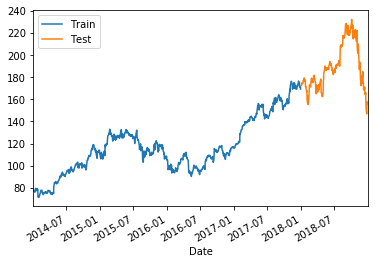

In [0]:

import matplotlib.pyplot as plt
import yfinance as yf  

train_data = yf.download('AAPL','2014-01-01','2018-01-01')
test_data = yf.download('AAPL','2018-01-01','2019-01-01')

train_data.Close.plot()
test_data.Close.plot()
plt.legend (["Train", "Test"])

clear_output()
plt.show()

As you can see our data is just a sequence of numbers ordered by time. 

In order to normalize our data we scale them between 0 and 1: 

In [0]:
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
scaler = MinMaxScaler(feature_range = (0, 1)).fit(train_data.Close.values.reshape(-1, 1))

train_scaled = scaler.transform(train_data.Close.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.Close.values.reshape(-1, 1))  

print ("train_scaled.shape :", train_scaled.shape)
print ("test_scaled.shape :", test_scaled.shape)

train_scaled.shape : (1007, 1)
test_scaled.shape : (251, 1)


Now we create our input output pairs from our sequence:

In [0]:
train_features_set = []  
train_labels = []  
for i in range(60, train_scaled.shape[0]):  
    train_features_set.append(train_scaled[i-60:i, 0])
    train_labels.append(train_scaled[i, 0])

We need to convert these lists to the numpy arrays before we can use them for training. Then in order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset which is 1007 in our case. The second dimension is the number of time steps which is 60 while the last dimension is the number of indicators. Since we are only using one feature, i.e Closing price, the number of indicators will be one.

In [0]:
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
train_features_set = np.reshape(train_features_set, (train_features_set.shape[0], train_features_set.shape[1], 1))

Now let's create and train a simple model, our model has a stack of 4 lstm layers and a single output layer: 

In [0]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout  

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))

# we have a single output so this layer has 1 unit
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(train_features_set, train_labels, epochs = 100, batch_size = 30)

clear_output()

Now we create our test features set similar to what we did with our training set:

In [0]:
test_scaled = scaler.transform(test_data.Close.values.reshape(-1, 1))  

test_features_set = []  
for i in range(60, test_scaled.shape[0]):  
    test_features_set.append(test_scaled[i-60:i, 0])
    
test_features_set = np.array(test_features_set)  
test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))

And finaly let's see the results:

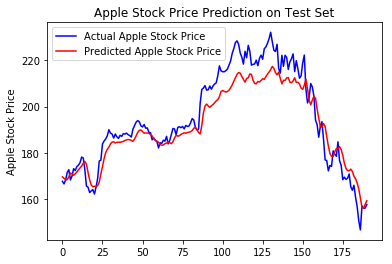

In [0]:
predictions = model.predict(test_features_set)
predictions = scaler.inverse_transform(predictions)  
  
plt.plot(test_data.Close.values[60:], color='blue', label='Actual Apple Stock Price')  
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction on Test Set')    
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()

* At first sight, it seems the predictions are following  pretty well the actual trend. What do you think about the result? Are you willing to risk using this predictions in real world? 

$\color{red}{\text{Write you answer here}}$

### 2. Predicting The Direction

Previous model can be evaluated  just visually. We can evaluate a classification task using its special measures (such as f-score or accuracy) much better than a regression task. So in order to finaly decide whether the stocks market prediction is practical or not, we define this second task.

Implement a model similar to previous one, this time the task is to predict whether the price is going to increase or decrease (output will be either 1 or 0 respectively) at time $T_i$ given prices at times $T_{i-60}$, ..., $T_{i-1}$ :

In [0]:
########################################
#     Put your implementation here     #
########################################

Evaluate your trained model using the test set and report accuracy and f1-score your model archived: 

In [0]:
########################################
#     Put your implementation here     #
########################################

Do not worry if your results are not as promising as before :))
* Comparing new results with previuos ones, why do you think this happens? Doesn't this task supposed to be an easier version of the previous one (if you are able to predict the actual price, you are already able to predict the direction of price trend)? Explain your toughts:


$\color{red}{\text{Write you answer here}}$

* Intuitively explain what kind of properties do you think a time series need to have in order to be predictable? 

$\color{red}{\text{Write you answer here}}$

# Submission

Congratulations! You finished the assignment & you're ready to submit your work. Please follow the instruction:

1. Check and review your answers. Make sure all of the cell outputs are what you want. 
2. Select File > Save.
3. Run **Create Submission** cell, It may take several minutes and it may ask you for your credential.
4. Run **Download Submission** cell to obtain your submission as a zip file.
5. Grab downloaded file (`dl_asg05__xx__xx.zip`) and submit it via https://forms.gle/CwxHWdgkjB4xfduw9.

**Note:** We need your Github token to create a new repository  (if it doesn't exist previously) in order to store learned model data. Also Google Drive token enables us to download the current notebook and Create the submission. If you are interested, feel free to check our code.

## Create Submission (Run the cell)

In [0]:
#@title
! pip install -U --quiet PyDrive > /dev/null
! wget -q https://github.com/github/hub/releases/download/v2.10.0/hub-linux-amd64-2.10.0.tgz 
  
import os
import time
import yaml
import json

from google.colab import files
from IPython.display import Javascript
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

asg_name = 'assignment_05'
script_save = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
repo_name = 'iust-deep-learning-assignments'
submission_file_name = 'dl_asg05__%s__%s.zip'%(student_id, student_name.lower().replace(' ',  '_'))
course_url = 'https://iust-deep-learning.github.io/972/'

! tar xf hub-linux-amd64-2.10.0.tgz
! cd hub-linux-amd64-2.10.0/ && chmod a+x install && ./install
! hub config --global hub.protocol https
! hub config --global user.email "$Your_Github_account_Email"
! hub config --global user.name "$student_name"
! hub api -X GET /user
! hub api -X GET /user > user_info.json
! hub api -F affiliation=owner -X GET /user/repos > repos.json

user_info = json.load(open('user_info.json'))
repos = json.load(open('repos.json'))
repo_names = [r['name'] for r in repos]
has_repository = repo_name in repo_names
if not has_repository:
  get_ipython().system_raw('! hub api -X POST -F name=%s /user/repos homepage="%s" > repo_info.json' % (repo_name, course_url))
  repo_info = json.load(open('repo_info.json')) 
  repo_url = repo_info['clone_url']
else:
  username = user_info['login']
  ! hub api -F homepage="$course_url" -X PATCH /repos/$username/$repo_name
  for r in repos:
    if r['name'] == repo_name:
      repo_url = r['clone_url']
  
stream = open("/root/.config/hub", "r")
token = list(yaml.load_all(stream))[0]['github.com'][0]['oauth_token']
repo_url_with_token = 'https://'+token+"@" +repo_url.split('https://')[1]

! git clone "$repo_url_with_token"
! cp -r "$ASSIGNMENT_PATH" "$repo_name"/
! cd "$repo_name" && git add -A
! cd "$repo_name" && git commit -m "Add assignment 05 results"
! cd "$repo_name" && git push -u origin master

sub_info = {
    'student_id': student_id,
    'student_name': student_name, 
    'repo_url': repo_url,
    'asg_dir_contents': os.listdir(str(ASSIGNMENT_PATH)),
    'datetime': str(time.time()),
    'asg_name': asg_name
}
json.dump(sub_info, open('info.json', 'w'))

Javascript(script_save)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('%s.ipynb'%asg_name) 

! jupyter nbconvert --to script "$asg_name".ipynb > /dev/null
! jupyter nbconvert --to html "$asg_name".ipynb > /dev/null
! zip "$submission_file_name" "$asg_name".ipynb "$asg_name".html "$asg_name".txt info.json > /dev/null

print("##########################################")
print("Done! Submisson created, Please download using the bellow cell!")

## Download Submission (Run the cell)

In [0]:
#@title
files.download(submission_file_name)

# References



1. Robbins, Herbert E. “A Stochastic Approximation Method,” 2007. https://doi.org/10.1214/aoms/1177729586.
2. He, K., X. Zhang, S. Ren, and J. Sun. “Deep Residual Learning for Image Recognition.” In 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770–78, 2016. https://doi.org/10.1109/CVPR.2016.90.
3. Wu, Yonghui, Mike Schuster, Zhifeng Chen, Quoc V. Le, Mohammad Norouzi, Wolfgang Macherey, Maxim Krikun, et al. “Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation.” ArXiv:1609.08144 [Cs], September 26, 2016. http://arxiv.org/abs/1609.08144.


